# Temporal Pattern Analysis and Feature Engineering

This notebook focuses on:
1. Decomposing temporal patterns into trend, seasonal, and residual components
2. Engineering temporal features for forecasting
3. Documenting feature selection rationale

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats


sns.set_palette('deep')
plt.rcParams['figure.figsize'] = [12, 6]

In [3]:
df = pd.read_csv('data/sazerac_df.csv', parse_dates=["date"])

# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.sort_index(inplace=True)

print('Dataset shape:', df.shape)
df.head()

Dataset shape: (1614362, 20)


,invoice_line_no,store,name,address,city,zipcode,store_location,county,category,category_name,itemno,im_desc,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,sale_bottles,sale_dollars,sale_liters,sale_gallons
date,,,,,,,,,,,,,,,,,,,,
2021-04-01,INV-35504200082,3757,WAL-MART 3590 / SIOUX CITY,3101 FLOYD BLVD,SIOUX CITY,51108.0,"{'type': 'Point', 'coordinates': [-96.37287, 4...",WOODBURY,1031100,AMERICAN VODKAS,38088,PLATINUM 7X VODKA,6,1750,9.44,14.16,6,84.96,10.5,2.77
2021-04-01,INV-35481800021,6136,RUSH STOP / CHARLES CITY,609 S MAIN ST,CHARLES CITY,50616.0,"{'type': 'Point', 'coordinates': [-92.682538, ...",FLOYD,1081600,WHISKEY LIQUEUR,64858,FIREBALL CINNAMON WHISKEY MINI DISPENSER,1,50,25.80,38.70,2,77.40,0.1,0.02
2021-04-01,INV-35489900001,2106,HILLSTREET NEWS AND TOBACCO,2217 COLLEGE,CEDAR FALLS,50613.0,"{'type': 'Point', 'coordinates': [-92.455796, ...",BLACK HAWK,1081000,AMERICAN CORDIALS & LIQUEURS,969618,SOOH DR MCGILLICUDDYS BUTTERSCOTCH,12,750,8.66,12.99,12,155.88,9.0,2.37
2021-04-01,INV-35503900011,4201,FAREWAY STORES #022 / SIOUX CITY,4040 WAR EAGLE DR,SIOUX CITY,51109.0,"{'type': 'Point', 'coordinates': [-96.461706, ...",WOODBURY,1081500,TRIPLE SEC,86390,MONTEZUMA TRIPLE SEC,12,1000,2.13,3.20,12,38.40,12.0,3.17
2021-04-01,INV-35504300085,2621,HY-VEE FOOD STORE #3 / SIOUX CITY,3301 GORDON DR,SIOUX CITY,51105.0,"{'type': 'Point', 'coordinates': [-96.364108, ...",WOODBURY,1031100,AMERICAN VODKAS,35318,BARTON VODKA,6,1750,6.92,10.38,6,62.28,10.5,2.77


## 1. Time Series Decomposition

We'll decompose the sales time series into its components:
- Trend: Long-term progression
- Seasonal: Recurring patterns
- Residual: Random variations

In trend_profiling.ipynb

## 2. Feature Engineering

We'll create several types of temporal features:
1. Lag features
2. Rolling statistics
3. Rate of change indicators
4. Time-based features

In [9]:
def create_temporal_features(df, feature='sale_dollars'):
    """Create temporal features for time series forecasting."""
    df_features = df.copy()
    
    # 1. Lag Features
    lags = [1, 7, 14, 30]  # Previous day, week, 2 weeks, month
    for lag in lags:
        df_features[f'sales_lag_{lag}'] = df_features[feature].shift(lag)
    
    # 2. Rolling Statistics
    windows = [7, 14, 30]  # Week, 2 weeks, month
    for window in windows:
        df_features[f'sales_rolling_mean_{window}'] = df_features[feature].rolling(window=window).mean()
        df_features[f'sales_rolling_std_{window}'] = df_features[feature].rolling(window=window).std()
        df_features[f'sales_rolling_max_{window}'] = df_features[feature].rolling(window=window).max()
        df_features[f'sales_rolling_min_{window}'] = df_features[feature].rolling(window=window).min()
    
    # 3. Rate of Change Features
    df_features['sales_pct_change'] = df_features[feature].pct_change()
    df_features['sales_diff'] = df_features[feature].diff()
    
    for window in windows:
        df_features[f'sales_momentum_{window}'] = (
            df_features[feature] - df_features[f'sales_rolling_mean_{window}'])
    
    # 4. Time-based Features
    df_features['day_of_week'] = df_features.index.dayofweek
    df_features['month'] = df_features.index.month
    df_features['quarter'] = df_features.index.quarter
    df_features['year'] = df_features.index.year
    df_features['is_weekend'] = df_features['day_of_week'].isin([5, 6]).astype(int)
    
    return df_features

# Create features
df_with_features = create_temporal_features(df)

# Display the first few rows and feature info
print("Feature Information:")
print(df_with_features.info())
print("\nSample of engineered features:")
df_with_features.head()

Feature Information:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1614362 entries, 2021-04-01 to 2025-01-31
Data columns (total 46 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   invoice_line_no        1614362 non-null  object 
 1   store                  1614362 non-null  int64  
 2   name                   1614362 non-null  object 
 3   address                1614362 non-null  object 
 4   city                   1614362 non-null  object 
 5   zipcode                1614362 non-null  float64
 6   store_location         1614362 non-null  object 
 7   county                 1614362 non-null  object 
 8   category               1614362 non-null  int64  
 9   category_name          1614362 non-null  object 
 10  itemno                 1614362 non-null  int64  
 11  im_desc                1614362 non-null  object 
 12  pack                   1614362 non-null  int64  
 13  bottle_volume_ml       1614362 non-n

,invoice_line_no,store,name,address,city,zipcode,store_location,county,category,category_name,...,sales_pct_change,sales_diff,sales_momentum_7,sales_momentum_14,sales_momentum_30,day_of_week,month,quarter,year,is_weekend
date,,,,,,,,,,,,,,,,,,,,,
2021-04-01,INV-35504200082,3757,WAL-MART 3590 / SIOUX CITY,3101 FLOYD BLVD,SIOUX CITY,51108.0,"{'type': 'Point', 'coordinates': [-96.37287, 4...",WOODBURY,1031100,AMERICAN VODKAS,...,NaN,NaN,NaN,NaN,NaN,3,4,2,2021,0
2021-04-01,INV-35481800021,6136,RUSH STOP / CHARLES CITY,609 S MAIN ST,CHARLES CITY,50616.0,"{'type': 'Point', 'coordinates': [-92.682538, ...",FLOYD,1081600,WHISKEY LIQUEUR,...,-0.088983,-7.56,NaN,NaN,NaN,3,4,2,2021,0
2021-04-01,INV-35489900001,2106,HILLSTREET NEWS AND TOBACCO,2217 COLLEGE,CEDAR FALLS,50613.0,"{'type': 'Point', 'coordinates': [-92.455796, ...",BLACK HAWK,1081000,AMERICAN CORDIALS & LIQUEURS,...,1.013953,78.48,NaN,NaN,NaN,3,4,2,2021,0
2021-04-01,INV-35503900011,4201,FAREWAY STORES #022 / SIOUX CITY,4040 WAR EAGLE DR,SIOUX CITY,51109.0,"{'type': 'Point', 'coordinates': [-96.461706, ...",WOODBURY,1081500,TRIPLE SEC,...,-0.753657,-117.48,NaN,NaN,NaN,3,4,2,2021,0
2021-04-01,INV-35504300085,2621,HY-VEE FOOD STORE #3 / SIOUX CITY,3301 GORDON DR,SIOUX CITY,51105.0,"{'type': 'Point', 'coordinates': [-96.364108, ...",WOODBURY,1031100,AMERICAN VODKAS,...,0.621875,23.88,NaN,NaN,NaN,3,4,2,2021,0


## 3. Feature Selection Rationale

Let's analyze the importance and rationale behind each feature category:

### Lag Features
- `sales_lag_1`: Captures immediate past behavior
- `sales_lag_7`: Weekly patterns
- `sales_lag_14`: Bi-weekly patterns
- `sales_lag_30`: Monthly patterns

### Rolling Statistics
- Rolling means: Capture trend over different time windows
- Rolling std: Measure volatility
- Rolling max/min: Capture extreme values and ranges

### Rate of Change
- Percentage change: Relative changes in sales
- Momentum: Deviation from moving averages

### Time-based Features
- Day of week: Weekly seasonality
- Month/Quarter: Seasonal patterns
- Weekend indicator: Special day patterns

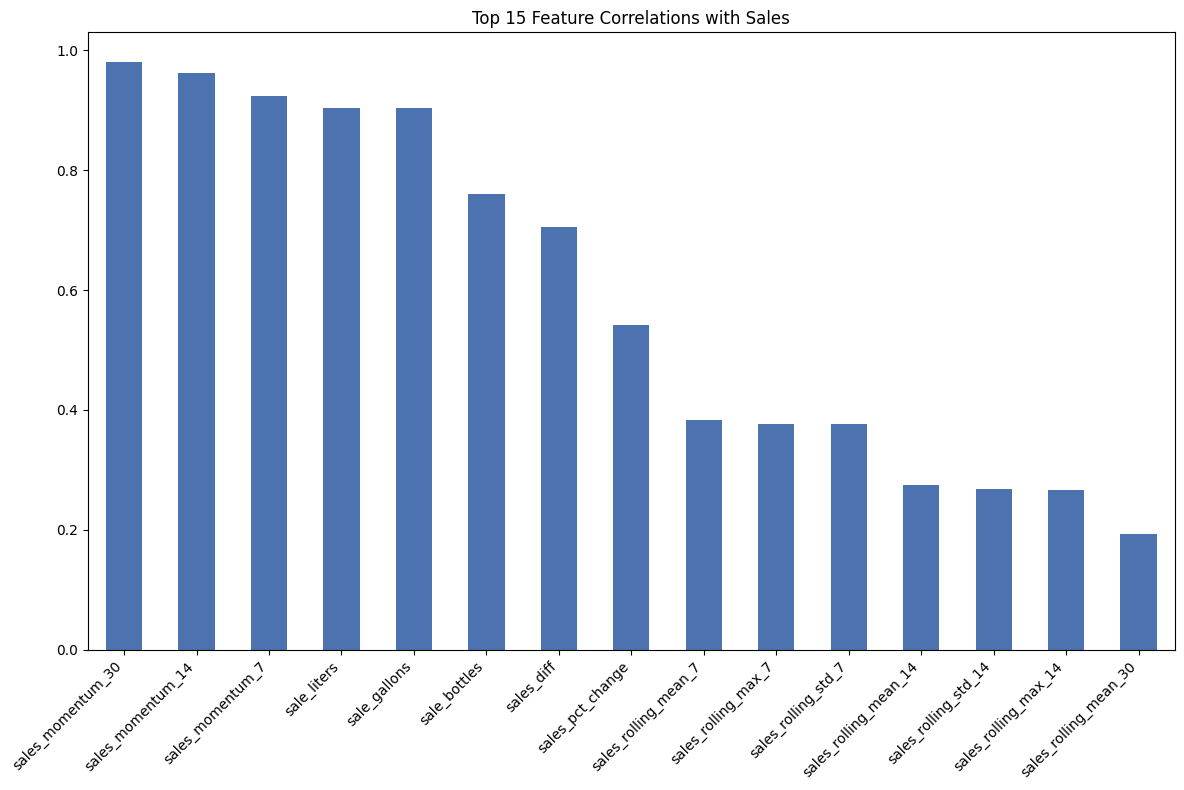


Top 15 correlated features:
sales_momentum_30        0.981210
sales_momentum_14        0.961580
sales_momentum_7         0.923778
sale_liters              0.903517
sale_gallons             0.903516
sale_bottles             0.760568
sales_diff               0.705631
sales_pct_change         0.542280
sales_rolling_mean_7     0.383082
sales_rolling_max_7      0.376831
sales_rolling_std_7      0.376475
sales_rolling_mean_14    0.274578
sales_rolling_std_14     0.267754
sales_rolling_max_14     0.266333
sales_rolling_mean_30    0.192356
Name: sale_dollars, dtype: float64


In [10]:
# Analyze feature correlations with target
def analyze_feature_importance(df, target='sale_dollars'):
    correlations = df.corr()[target].sort_values(ascending=False)
    
    plt.figure(figsize=(12, 8))
    correlations[1:16].plot(kind='bar')  # Exclude self-correlation
    plt.title('Top 15 Feature Correlations with Sales')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    return correlations

correlations = analyze_feature_importance(df_with_features.select_dtypes(include=[np.number]))
print("\nTop 15 correlated features:")
print(correlations[1:16])

## Feature Selection Recommendations

Based on the correlation analysis and the observed patterns in the data, here are the recommended features grouped by their importance:

### 1. Primary Features (Very High Importance, |correlation| > 0.9)
- Momentum indicators:
  * `sales_momentum_30` (0.981)
  * `sales_momentum_14` (0.962)
  * `sales_momentum_7` (0.924)
- Volume metrics:
  * `sale_liters` (0.904)
  * `sale_gallons` (0.904)

Rationale: These features show the strongest correlation with sales and capture both the deviation from moving averages and the actual volume of transactions.

### 2. Secondary Features (Strong Importance, 0.5 < |correlation| < 0.9)
- `sale_bottles` (0.761)
- `sales_diff` (0.706)
- `sales_pct_change` (0.542)

Rationale: These features provide important information about sales dynamics and rate of change, offering complementary signals to the primary features.

### 3. Supporting Features (Moderate Importance, 0.2 < |correlation| < 0.5)
Rolling statistics (7-day window):
- `sales_rolling_mean_7` (0.383)
- `sales_rolling_max_7` (0.377)
- `sales_rolling_std_7` (0.376)

Rolling statistics (14-day window):
- `sales_rolling_mean_14` (0.275)
- `sales_rolling_std_14` (0.268)
- `sales_rolling_max_14` (0.266)

Rationale: While showing lower correlation, these features capture important statistical patterns and volatility in different time windows.

### 4. Contextual Features (To be included despite lower correlation)
- Time-based features (day of week, month, quarter)
- Holiday indicators
- Weekend/weekday flags

Rationale: Although these features might show lower direct correlation, they are crucial for capturing seasonality and special events that influence sales patterns.

### Implementation Strategy:
1. Start with Primary Features as the base model inputs
2. Add Secondary Features to capture rate-of-change dynamics
3. Selectively include Supporting Features based on model performance
4. Always include Contextual Features to capture temporal patterns

In [12]:
# Save the engineered features
df_with_features.to_csv('data/sales_with_temporal_features.csv')
print("Features saved to 'data/sales_with_temporal_features.csv'")

Features saved to 'data/sales_with_temporal_features.csv'
